<a href="https://colab.research.google.com/github/SairilTomar/Sales_Forecasting_XGBoost/blob/main/Sales_Forecast_using_xgBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all the required libraries


In [80]:
# IMPORTING THE NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Dataset

In [81]:
store_sales = pd.read_csv('train.csv')
store_sales.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,26,92,2011-08-26,87235.57,False,61.10,3.796,NaN,NaN,NaN,NaN,NaN,136.213613,7.767,A,152513
1,34,22,2011-03-25,5945.97,False,53.11,3.480,NaN,NaN,NaN,NaN,NaN,128.616064,10.398,A,158114
2,21,28,2010-12-03,1219.89,False,50.43,2.708,NaN,NaN,NaN,NaN,NaN,211.265543,8.163,B,140167


# Data Cleaning


In [82]:
# Detecting outliers
store_sales.describe()


,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,282451.000000,282451.000000,282451.000000,282451.000000,282451.000000,100520.000000,74232.000000,91521.000000,90031.000000,101029.000000,282451.000000,282451.000000,282451.000000
mean,22.193166,44.286138,15983.429692,60.113640,3.360300,7246.077559,3318.408122,1417.397841,3379.591745,4639.476021,171.207802,7.968098,136730.073220
std,12.782138,30.503641,22661.092494,18.446485,0.458602,8254.606267,9485.575898,9547.858949,6269.428446,6060.459590,39.160808,1.868070,61002.319363
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.330000,46.780000,2.932000,2241.190000,40.960000,5.060000,508.100000,1877.810000,132.022667,6.891000,93638.000000
50%,22.000000,38.000000,7616.550000,62.150000,3.452000,5363.520000,191.820000,24.340000,1482.030000,3364.410000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20245.745000,74.290000,3.737000,9235.590000,1919.790000,103.130000,3607.570000,5563.800000,212.464799,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


# We will use these two columns for further modelling :- Date and Weekly_Sales

In [83]:
store_sales = store_sales[['Date', 'Weekly_Sales']]
store_sales['Date'] = pd.to_datetime(store_sales['Date'])

# Removing duplicates if any

In [84]:
store_sales.shape

(282451, 2)

In [85]:
store_sales.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", store_sales.shape)

Shape after removing duplicates: (279987, 2)


# Detecting outliers

In [86]:
store_sales.describe()

,Date,Weekly_Sales
count,279987,279987.000000
mean,2011-06-17 11:00:03.278723584,16121.236962
min,2010-02-05 00:00:00,-4988.940000
25%,2010-10-08 00:00:00,2181.340000
50%,2011-06-17 00:00:00,7749.800000
75%,2012-02-24 00:00:00,20409.520000
max,2012-10-26 00:00:00,693099.360000
std,NaN,22712.248904


# we can see the presence of outliers in Weekly_Sales column as min and max are making it obvious

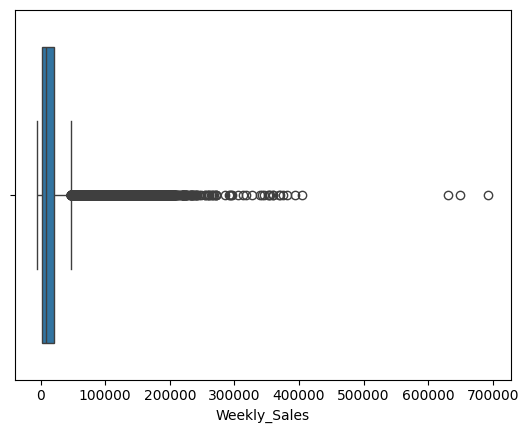

In [87]:
sns.boxplot(x = "Weekly_Sales", data = store_sales)
plt.show()

/tmp/ipython-input-4155318771.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(store_sales["Weekly_Sales"])


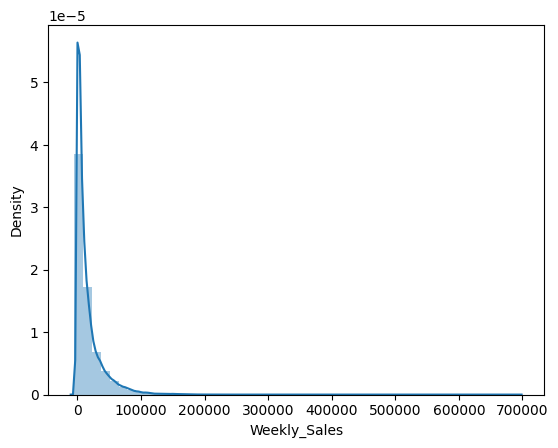

In [88]:
sns.distplot(store_sales["Weekly_Sales"])
plt.show()

# This indicates the presence of outliers in the dataset



# Removing them-> using IQR Method

In [89]:
store_sales.shape

(279987, 2)

In [90]:
q1 = store_sales['Weekly_Sales'].quantile(0.25)
q3 = store_sales["Weekly_Sales"].quantile(0.75)
q1


np.float64(2181.34)

In [91]:
q3

np.float64(20409.52)

In [92]:
IQR = q3-q1
min_range = q1 - (1.5*IQR)

In [93]:
max_range = q3+ (1.5*IQR)

In [94]:
min_range, max_range

(np.float64(-25160.93), np.float64(47751.79))

In [95]:
store_sales[store_sales["Weekly_Sales"]<=max_range]

,Date,Weekly_Sales
1,2011-03-25,5945.97
2,2010-12-03,1219.89
3,2010-09-17,11972.71
4,2012-05-18,8271.82
6,2010-08-06,18882.41
...,...,...
282446,2012-10-19,20775.91
282447,2010-05-21,5350.00
282448,2010-04-30,10939.87
282449,2011-07-01,5013.89


In [96]:
#storing the above in a variable
new_dataset = store_sales[store_sales["Weekly_Sales"]<=max_range]
new_dataset.shape

(256524, 2)

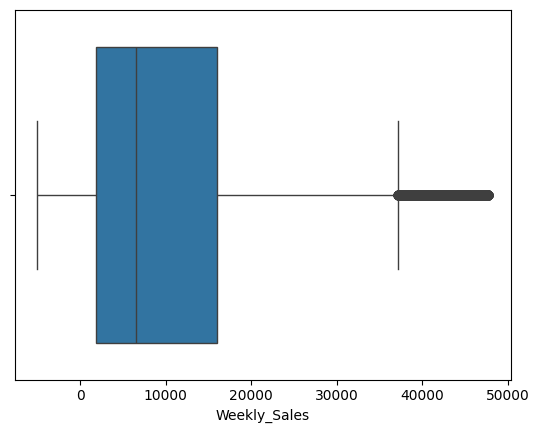

In [97]:
# Using boxplot to see how cleaned dataset

sns.boxplot(x="Weekly_Sales", data = new_dataset)
plt.show()

/tmp/ipython-input-2339746045.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_dataset["Weekly_Sales"])


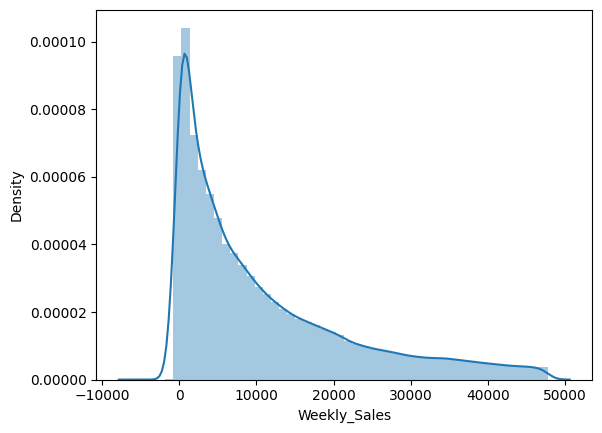

In [98]:
# Using distribution plot to clearly understand that outliers are removed

sns.distplot(new_dataset["Weekly_Sales"])
plt.show()

# Thus these plots above visually confirms the removal of outliers from the dataset

# Using Feature Engineering

In [99]:
store_sales['Month'] = store_sales['Date'].dt.to_period('M')
monthly_sales = store_sales.groupby('Month')['Weekly_Sales'].sum().reset_index()
monthly_sales['Monthly'] = monthly_sales['Month'].dt.to_timestamp()

In [100]:
monthly_sales['sales_diff'] = monthly_sales['Weekly_Sales'].diff()
# Time features
monthly_sales['month_num'] = monthly_sales['Month'].dt.month
monthly_sales['quarter'] = monthly_sales['Month'].dt.quarter

# Holiday flag
monthly_sales['holiday_flag'] = monthly_sales['month_num'].apply(lambda x: 1 if x in [11,12] else 0)

# Rolling statistics
monthly_sales['rolling_mean_3'] = monthly_sales['Weekly_Sales'].rolling(window=3).mean()
monthly_sales['rolling_mean_6'] = monthly_sales['Weekly_Sales'].rolling(window=6).mean()

# Drop NA
monthly_sales = monthly_sales.dropna().reset_index(drop=True)


# Creating Supervised Data

In [101]:
features = ['sales_diff', 'month_num', 'quarter', 'holiday_flag', 'rolling_mean_3', 'rolling_mean_6']
supervised_data = monthly_sales[features].copy()

In [102]:
for i in range(1, 7):
    supervised_data[f'sales_lag_{i}'] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [103]:
X = supervised_data.drop('sales_diff', axis=1)
y = supervised_data['sales_diff']


# Doing Train-Test-Split


In [104]:
train_size = len(supervised_data) - 12
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Normalization (Min-Max Scaling)
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Using XGBoost Algo

In [105]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

xgb_mse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print("XGBoost MSE:", xgb_mse)
print("XGBoost MAE:", xgb_mae)
print("XGBoost R2:", xgb_r2)

XGBoost MSE: 14164121.718280498
XGBoost MAE: 11289627.408333337
XGBoost R2: 0.8562777335704681


# Visualization

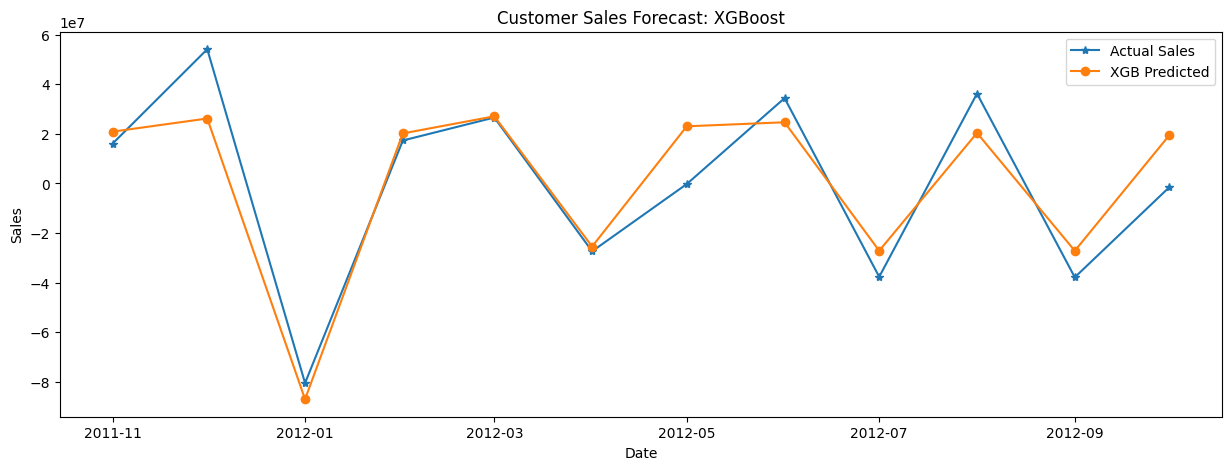

In [109]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Monthly'][-len(y_test):], y_test, label='Actual Sales', marker='*')


plt.plot(monthly_sales['Monthly'][-len(y_test):], xgb_pred, label='XGB Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Customer Sales Forecast: XGBoost')
plt.legend()
plt.show()